# Apply HUX Mapping Technique to in-situ spacecraft observations


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import pickle
import datetime as dt 

from heliopy.data import psp
from heliopy.data import omni
from heliopy.data import stereo
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u
from heliopy.data.solo import download

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable


from hux_propagation import *

# matplotlib fontsize
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) solutions 
### for CR 2210, 2215, 2221, 2226, 2231, 2235, and 2239 which contained each of the perihelia P1, P2, P3, P4, P5, P6, and P7, respectively.


# TODO: 
    1. ASK PETE ABOUT P1 -- ISNT IT CONTAINED IN 2210 INSTEAD OF 2200?
    2. Reach out to David or create your own function to sample sample from mhd solutions when r <30. 
    3. Apply the ballistic approximation
    4. Make periodic graph automatically periodic...
    5. Attempt to modify HUX to have an initial condition that varies in radial values. 


Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [2]:
# set up - perihelion p1-p7
case_study = "p1"

if case_study == "p1":
    # Carrington Rotation 2210
    # 2018 Oct 26	2018 Nov 23
    # Encounter 1 date: 2018-11-06. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2018, month=10, day=26)
    endtime = dt.datetime(year=2018, month=11, day=23)
    cr = "2210"
    
elif case_study == "p2":
    # TODO: DEBUG OMNI DATASET LOAD FOR THIS TIME INTERVAL. 
    # Carrington Rotation 2215
    # 2019 Mar 12	2019 Apr 08
    # Encounter 2 date: 2019-04-04. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2019, month=3, day=12)
    endtime = dt.datetime(year=2019, month=4, day=8)
    cr = "2215"
    
elif case_study == "p3":
    # Carrington Rotation 2221
    # 2019 Aug 22	2019 Sep 19
    # Encounter 3 date: 2019-09-01. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2019, month=8, day=22)
    endtime = dt.datetime(year=2019, month=9, day=19)
    cr = "2221"

elif case_study == "p4":
    # Carrington Rotation 2226
    # 2020 Jan 06	2020 Feb 02
    # Encounter 4 date: 2020-01-29. Distance from the center of the sun: 0.13 au (27.8 RS)
    starttime = dt.datetime(year=2020, month=1, day=6)
    endtime = dt.datetime(year=2020, month=2, day=2)
    cr = "2226"
    
elif case_study == "p5":
    # Carrington Rotation 2231 
    # 2020 May 21	2020 Jun 18
    # Encounter 5 date: 2020-06-07. Distance from the center of the sun: 0.13 au (27.8 RS)
    starttime = dt.datetime(year=2020, month=5, day=21)
    endtime = dt.datetime(year=2020, month=6, day=18)
    cr = "2231"
    
    
elif case_study == "p6":
    # todo: PSP VR DATA IS NOT AVAILABLE. 
    # Carrington Rotation 2235 
    # 2020 Sep 07	2020 Oct 05
    # Encounter 6 date: 2020-09-27. Distance from the center of the sun: 0.09 au (20.3 RS)
    starttime = dt.datetime(year=2020, month=9, day=7)
    endtime = dt.datetime(year=2020, month=10, day=5)
    cr = "2235"

elif case_study == "p7":
    # todo: PSP VR DATA IS NOT AVAILABLE. 
    # Carrington Rotation 2239
    # 2020 Dec 25	2021 Jan 22
    # Encounter 7 date: 2021-01-17. Distance from the center of the sun: 0.09 au (20.3 RS)
    starttime = dt.datetime(year=2020, month=12, day=25)
    endtime = dt.datetime(year=2021, month=1, day=22)
    cr = "2239"

In [3]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr=cr)

model = MASOutput(mas_path)

print(model.variables)

['br', 'rho', 'vr']


In [4]:
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [6]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [8]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [9]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [10]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [11]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

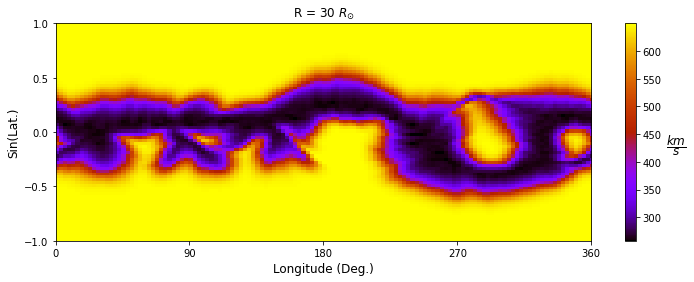

In [12]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/' + case_study + '/vr_30rs_map.png')

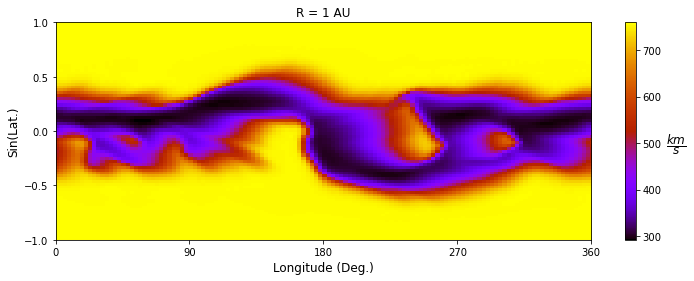

In [13]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/' + case_study + '/vr_1au_map.png')

# Apply HUX-f and HUX-b

The HUX underlying PDE

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

The HUX-f technique leverages the forward finite difference approximation, such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


<!-- $$
v_{i+1, j}\frac{v_{i, j}}{\Delta r} - \frac{v_{i, j}^2}{\Delta r} 
= \Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi}
$$


$$
v_{i+1, j}\frac{v_{i, j}}{\Delta r}
= \Omega_{rot} \frac{v_{i, j+1}}{\Delta \phi} - \Omega_{rot}\frac{v_{i, j}}{\Delta \phi} +  \frac{v_{i, j}^2}{\Delta r} 
$$


$$
v_{i+1, j}
= \frac{\Delta r}{v_{i, j}}(\Omega_{rot} \frac{v_{i, j+1}}{\Delta \phi} - \Omega_{rot}\frac{v_{i, j}}{\Delta \phi} +  \frac{v_{i, j}^2}{\Delta r})
$$
 -->
$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{\Delta \phi}  (\frac{v_{i, j+1} - v_{i, j}}{v_{i, j}})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{\Delta \phi}  (v_{i, j}-\frac{v_{i, j-1}}{v_{i, j}})
$$

where for simplicity the $r$ subscipt on the radial velocity is ommitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively. 

In [14]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec = r_plot[1:] - r_plot[:-1]
dp_vec = p[1:] - p[:-1]

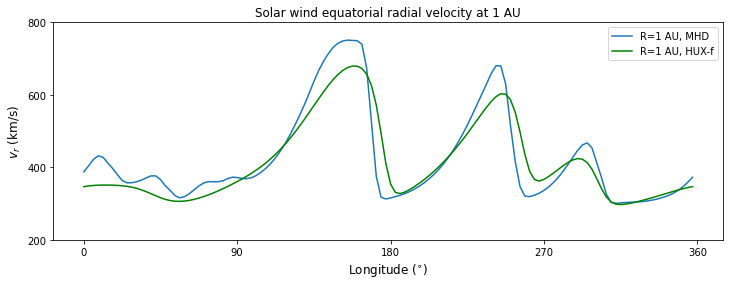

In [15]:
fig, ax = plt.subplots(figsize = (12,4))

_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="R=1 AU, MHD")
_ = ax.plot(p*180/np.pi, apply_forward_upwind_model(solar_equator_r_30_radii, dr_vec, dp_vec), 'g',label="R=1 AU, HUX-f")

_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/' + case_study + '/vr_1AU_ts_comp_MHD_HUX-f.png')

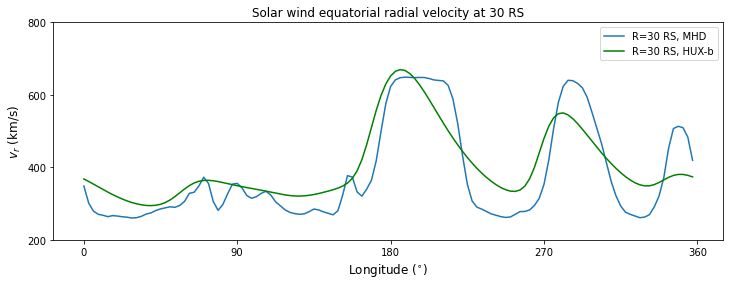

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))

_ = ax.plot(p*180/np.pi, solar_equator_r_30_radii , label="R=30 RS, MHD")
_ = ax.plot(p*180/np.pi, apply_backwards_upwind_model(solar_equator_r_1_au, dr_vec, dp_vec), 'g',label="R=30 RS, HUX-b")

_ = ax.set_title("Solar wind equatorial radial velocity at 30 RS",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/' + case_study + '/vr_30RS_ts_comp_MHD_HUX-b_cr' + str(cr) +'.png')

In [17]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r))),  np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], dr_vec, dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_b_model(f[:, ii, -1], dr_vec, dp_vec).T

In [18]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0, :, :]], axis=0)
hux_b_res_plot = np.append(hux_b_res,[hux_b_res[0, :, :]], axis=0)

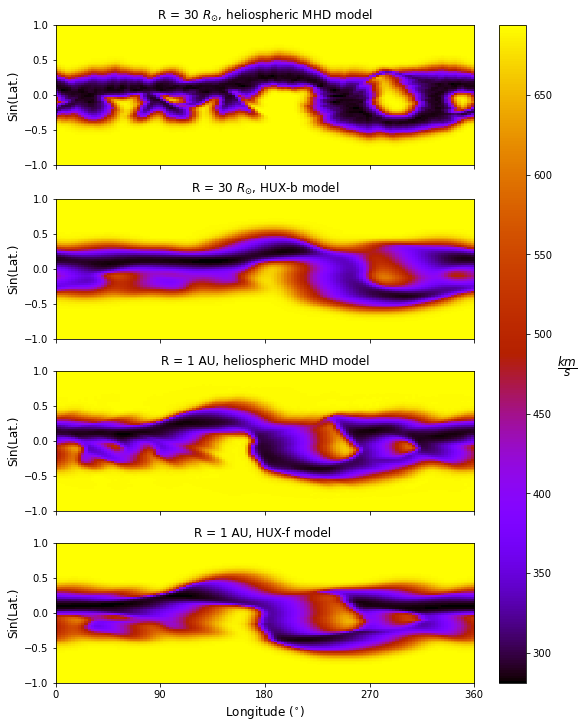

In [19]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$, heliospheric MHD model", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)

ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 30 $R_{\odot}$, HUX-b model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, hux_b_res_plot[:, :, 0].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[3].set_ylim(-1, 1)
ax[3].set_xlim(0, 360)
ax[3].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[3].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[3].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/' + case_study + '/vr_lon_lat_maps_MHD_HUX.png')

# Read in Parker Solar Probe (PSP) observations

Here we load the merged magnetic field and plasma data product, which has
an hourly data cadence.

In [20]:
psp_data = psp.merged_mag_plasma(starttime, endtime)
print("Available data = ", psp_data.columns)

Available data =  ['radialDistance', 'heliographicLatitude', 'heliographicLongitude', 'BR', 'BT', 'BN', 'B', 'VR', 'VT', 'VN', 'ProtonSpeed', 'flow_theta', 'flow_lon', 'protonDensity', 'protonTemp']


In [21]:
psp_data.data

,radialDistance,heliographicLatitude,heliographicLongitude,BR,BT,BN,B,VR,VT,VN,ProtonSpeed,flow_theta,flow_lon,protonDensity,protonTemp
Time,,,,,,,,,,,,,,,
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0


Generate the PSP trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [22]:
times = psp_data.index

spicedata.get_kernel('psp')
spicedata.get_kernel('psp_pred')
psp_traj = spice.Trajectory('SPP')
psp_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
psp_coords = psp_traj.coords

Here we sample the MHD and HUX velocity results at PSP location. 


In [23]:
hux_f_model = copy.deepcopy(vr_model)
hux_f_model.data.data = hux_f_res

hux_b_model = copy.deepcopy(vr_model)
hux_b_model.data.data = hux_b_res

In [24]:
vr_sampled_hux_f = hux_f_model.sample_at_coords(psp_coords.lon,
                                                psp_coords.lat,
                                                psp_coords.radius)

vr_sampled_hux_b = hux_b_model.sample_at_coords(psp_coords.lon,
                                                psp_coords.lat,
                                                psp_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(psp_coords.lon,
                                           psp_coords.lat,
                                           psp_coords.radius)

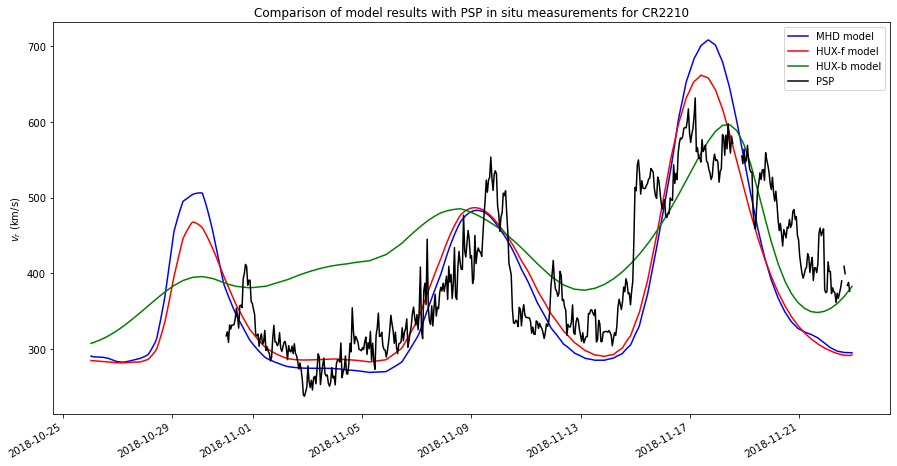

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(times, vr_sampled_mhd, color="b", label='MHD model')
ax.plot(times, vr_sampled_hux_f, color="r",label='HUX-f model')
ax.plot(times, vr_sampled_hux_b, color="g",label='HUX-b model')
ax.plot(times, psp_data.quantity('VR'), color="k", label='PSP')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/'+ case_study + '/psp_comparison_cr'+ str(cr)+ '_time.png')

216


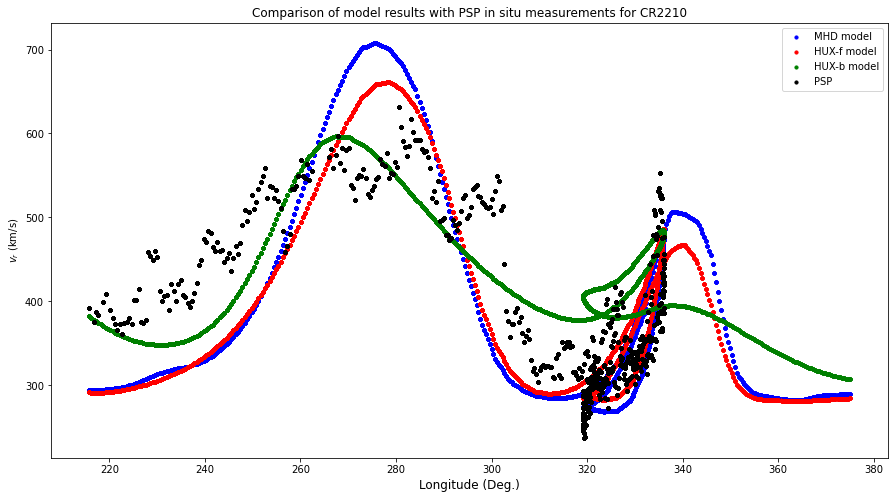

In [29]:
lon_psp = np.array(psp_coords.lon)

max_indx=np.argmax(psp_coords.lon)
print(max_indx)
add_periodicity = 360

fig, ax = plt.subplots(figsize=(15, 8))
size = 10

ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_mhd[:max_indx], color="b", s=size, label="MHD model")
ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_hux_f[:max_indx], color="r", s=size, label="HUX-f model")
ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_hux_b[:max_indx], color="g",s=size,  label="HUX-b model")
ax.scatter(lon_psp[:max_indx]+ add_periodicity, psp_data.quantity('VR')[:max_indx], color="k",s=size,  label="PSP")

ax.scatter(lon_psp[max_indx:], vr_sampled_mhd[max_indx:], s=size, color="b")
ax.scatter(lon_psp[max_indx:], vr_sampled_hux_f[max_indx:], s=size, color="r")
ax.scatter(lon_psp[max_indx:], vr_sampled_hux_b[max_indx:], s=size, color="g")
ax.scatter(lon_psp[max_indx:], psp_data.quantity('VR')[max_indx:],s=size, color="k")


ax.set_ylabel(r'$v_{r}$ (km/s)')
#ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of model results with PSP in situ measurements for CR" + str(cr))
ax.legend()
plt.savefig('figures/'+ case_study + '/psp_comparison_cr' + str(cr) + '_carrington_longitude.png')

# Read in OMNI (Earth) Observations

• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [30]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [31]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-26 01:00:00,6.370774e+13,2526,51,52,59,33,5.3,4.6,5.800000,153.600006,...,68.300003,20,-3,9999,7,99999,99999,1.1,0.006018,0.0130
2018-10-26 02:00:00,6.370774e+13,2526,51,52,61,37,5.0,4.3,23.299999,176.800003,...,68.300003,20,2,9999,7,99999,99999,0.2,0.006018,0.0117
2018-10-26 03:00:00,6.370774e+13,2526,51,52,62,36,4.8,4.6,28.000000,123.199997,...,68.300003,13,6,9999,5,99999,99999,0.2,0.006018,0.0091
2018-10-26 04:00:00,6.370775e+13,2526,51,52,61,37,2.2,2.0,4.400000,144.500000,...,68.300003,13,11,9999,5,99999,99999,0.5,0.006018,0.0011
2018-10-26 05:00:00,6.370775e+13,2526,51,52,60,31,2.2,1.9,-1.900000,194.500000,...,68.300003,13,12,9999,5,99999,99999,0.2,0.006018,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 19:00:00,6.371013e+13,2527,51,52,61,34,4.3,4.1,23.200001,332.399994,...,67.500000,3,-2,9999,2,99999,99999,0.1,0.005990,0.0257
2018-11-22 20:00:00,6.371014e+13,2527,51,52,61,36,4.4,4.2,14.100000,316.000000,...,67.500000,3,-1,9999,2,99999,99999,0.0,0.005990,0.0313
2018-11-22 21:00:00,6.371014e+13,2527,51,52,64,39,4.2,3.3,2.200000,264.000000,...,67.500000,0,3,9999,0,99999,99999,0.1,0.005990,0.0152


Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [32]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=omni_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

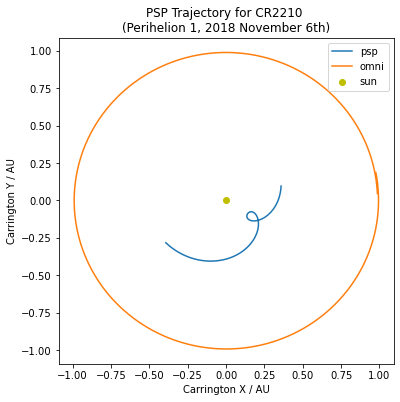

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
_ = ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="psp")
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="omni")
_ = ax.scatter(0, 0, color="y", label="sun")
#_ = ax.set_xlim(-1, 1)
#_ = ax.set_ylim(-1, 1)
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("PSP Trajectory for CR2210 \n(Perihelion 1, 2018 November 6th)")
plt.savefig('figures/'+ case_study + '/psp_cr2210_trajectory_location.png')

In [34]:
vr_sampled_hux_f_omni = hux_f_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_hux_b_omni = hux_b_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

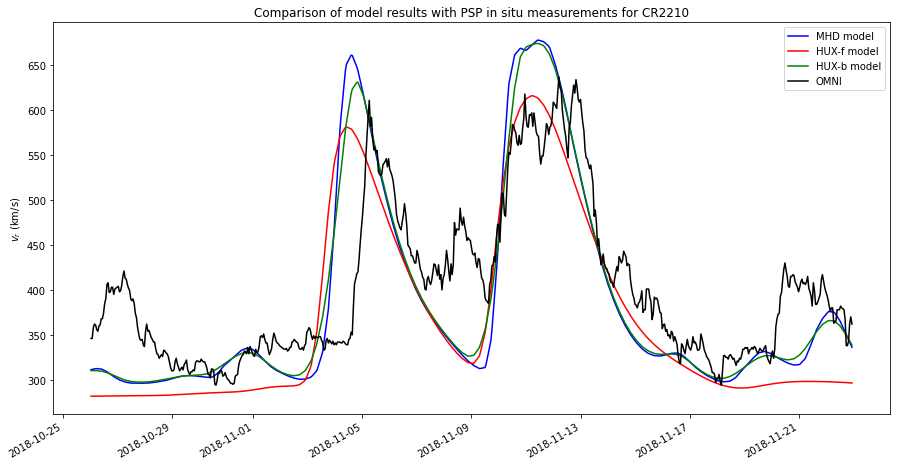

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(omni_data.index, vr_sampled_mhd_omni, color="b", label='MHD model')
ax.plot(omni_data.index, vr_sampled_hux_f_omni, color="r", label='HUX-f model')
ax.plot(omni_data.index, vr_sampled_hux_b_omni, color="g", label='HUX-b model')
ax.plot(omni_data.index, omni_data.quantity('V'),color="k", label='OMNI')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/'+ case_study + '/omni_comparison_cr' + str(cr) + '_time.png')

In [36]:
min_index = np.argmin(earth_coords.lon)

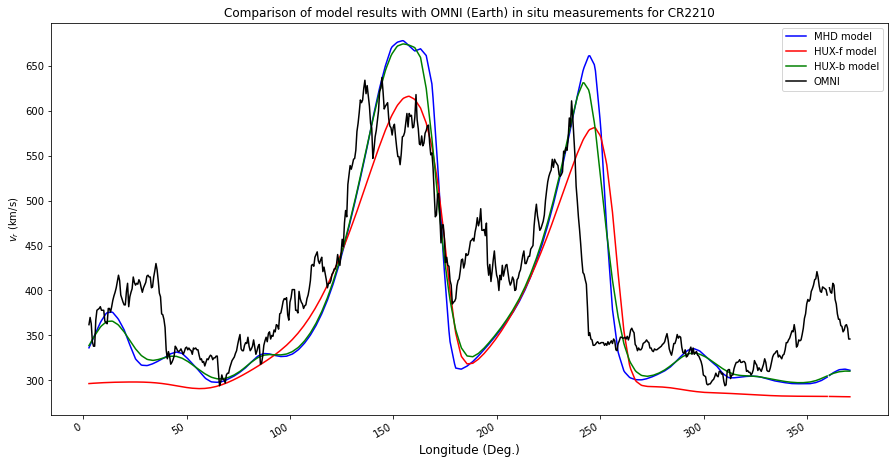

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="b", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_f_omni[:min_index], color="r", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_b_omni[:min_index], color="g", label="HUX-b model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_data.quantity('V')[:min_index], color="k", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="b")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_f_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_b_omni[min_index+1:], color="g")
ax.plot(earth_coords.lon[min_index+1:], omni_data.quantity('V')[min_index+1:], color="k")

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of model results with OMNI (Earth) in situ measurements for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/'+ case_study + '/omni_comparison_cr' + str(cr) + '_lon.png')

# Mapping PSP to OMNI (Earth) using the HUX and Ballistic Technique

# Assumptions: 
- Latitude is constant in PSP trajectory coordinatesNote that HUX is dependent on $\phi$ and $r$ only. 
- PSP and Earth are aligned in latitude. 
- $\phi$ is monotonically increasing - notice that in perihelion 1 psp orbit loops back and therefore we exclude that section for now. 

In [38]:
print("Latitude standard deviation of PSP Trajectory (Deg)", np.std(np.array(psp_traj.coords.lat)))
print("Latitude mean of PSP Trajectory (Deg)", np.mean(np.array(psp_traj.coords.lat)))

Latitude standard deviation of PSP Trajectory (Deg) 1.9869956179855046
Latitude mean of PSP Trajectory (Deg) -0.8186404711115175


In [39]:
print("Radial standard deviation of PSP Trajectory", np.std(psp_traj.coords.radius.to(u.solRad)))
print("Radial mean of PSP Trajectory", np.mean(psp_traj.coords.radius.to(u.solRad)))
print("Radial min of PSP Trajectory", np.min(psp_traj.coords.radius.to(u.solRad)))
print("Radial max of PSP Trajectory", np.max(psp_traj.coords.radius.to(u.solRad)))

Radial standard deviation of PSP Trajectory 21.341676463501877 solRad
Radial mean of PSP Trajectory 61.61345269048294 solRad
Radial min of PSP Trajectory 35.67457835584172 solRad
Radial max of PSP Trajectory 104.0766974779868 solRad


In [40]:
print("Latitude standard deviation of OMNI (Earth) Trajectory (Deg)", np.std(np.array(earth_traj.coords.lat)))
print("Latitude mean of OMNI (Earth) Trajectory (Deg)", np.mean(np.array(earth_traj.coords.lat)))

Latitude standard deviation of OMNI (Earth) Trajectory (Deg) 0.887943206230284
Latitude mean of OMNI (Earth) Trajectory (Deg) 3.5240955726323677


In [41]:
print("Radial standard deviation of OMNI (Earth) Trajectory", np.std(earth_traj.coords.radius.to(u.solRad)))
print("Radial mean of OMNI (Earth) Trajectory", np.mean(earth_traj.coords.radius.to(u.solRad)))
print("Radial min of OMNI (Earth) Trajectory", np.min(earth_traj.coords.radius.to(u.solRad)))
print("Radial max of OMNI (Earth) Trajectory", np.max(earth_traj.coords.radius.to(u.solRad)))

Radial standard deviation of OMNI (Earth) Trajectory 0.4159182950302567 solRad
Radial mean of OMNI (Earth) Trajectory 213.03718841328143 solRad
Radial min of OMNI (Earth) Trajectory 212.35364314703682 solRad
Radial max of OMNI (Earth) Trajectory 213.78361569427273 solRad


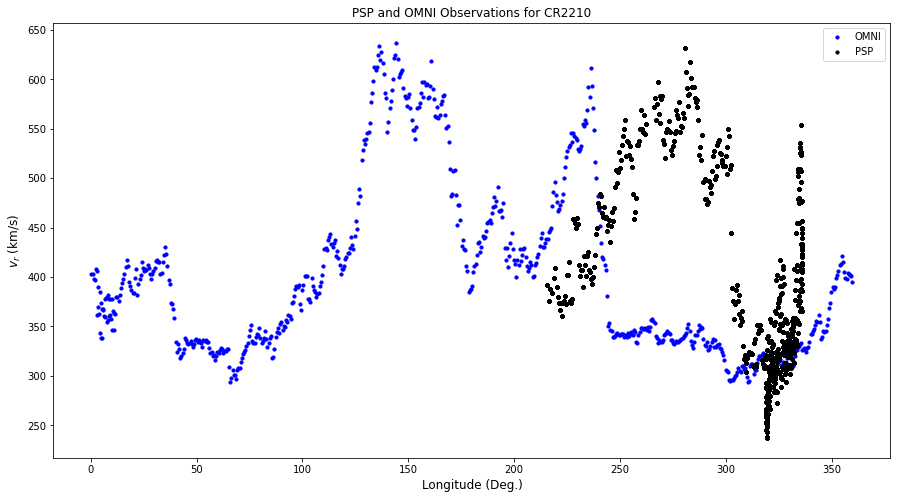

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = ax.scatter(earth_coords.lon, omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(psp_coords.lon, psp_data.quantity('VR'), color="k", s=size, label="PSP")

_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
_ = ax.set_title("PSP and OMNI Observations for CR" + str(cr))
plt.savefig('figures/'+ case_study + '/omni_and_psp_vr_vs_carringtonlon' + str(cr) +'.png')

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [44]:
# create uniform phi 1d mesh grid. 
phi_array = np.linspace(0, 360, 360)

In [45]:
# interpolate 1D (0, 360)
interp_omni = scipy.interpolate.interp1d(earth_coords.lon, omni_data.quantity('V'), 
                                         bounds_error=False, 
                                         fill_value="extrapolate")

interp_psp = scipy.interpolate.interp1d(psp_coords.lon, psp_data.quantity('VR'), 
                                        bounds_error=False, 
                                        fill_value="extrapolate")

In [46]:
earth_vr_interp = interp_omni(phi_array)
psp_vr_interp = interp_psp(phi_array)

In [47]:
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi 
dp_vec_hux = p_hux[1:] - p_hux[:-1]

### Note that we set velocity acceleration after upwind to 'False'

In [48]:
r_hux = np.linspace(np.mean(psp_coords.radius), np.mean(earth_coords.radius), 150)
res_hux_f_mean = apply_forward_upwind_model(r_initial=np.nan_to_num(psp_vr_interp, nan=400),
                                      dr_vec=r_hux.value[1:] - r_hux.value[:-1],
                                      dp_vec=dp_vec_hux, 
                                      add_v_acc=False, 
                                      r0=r_hux[0].value)

res_hux_b_mean = apply_backwards_upwind_model(r_final=np.nan_to_num(earth_vr_interp, nan=400), 
                                         dr_vec=r_hux.value[1:] - r_hux.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_hux[0].value, 
                                         add_v_acc=False)

r_hux = np.linspace(np.min(psp_coords.radius), np.mean(earth_coords.radius), 150)
res_hux_f_min = apply_forward_upwind_model(r_initial=np.nan_to_num(psp_vr_interp, nan=400),
                                      dr_vec=r_hux.value[1:] - r_hux.value[:-1],
                                      dp_vec=dp_vec_hux, 
                                      add_v_acc=False, 
                                      r0=r_hux[0].value)

res_hux_b_min = apply_backwards_upwind_model(r_final=np.nan_to_num(earth_vr_interp, nan=400), 
                                         dr_vec=r_hux.value[1:] - r_hux.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_hux[0].value, 
                                         add_v_acc=False)


r_hux = np.linspace(np.max(psp_coords.radius), np.mean(earth_coords.radius), 150)
res_hux_f_max = apply_forward_upwind_model(r_initial=np.nan_to_num(psp_vr_interp, nan=400),
                                      dr_vec=r_hux.value[1:] - r_hux.value[:-1],
                                      dp_vec=dp_vec_hux, 
                                      add_v_acc=False, 
                                      r0=r_hux[0].value)

res_hux_b_max = apply_backwards_upwind_model(r_final=np.nan_to_num(earth_vr_interp, nan=400), 
                                         dr_vec=r_hux.value[1:] - r_hux.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_hux[0].value, 
                                         add_v_acc=False)

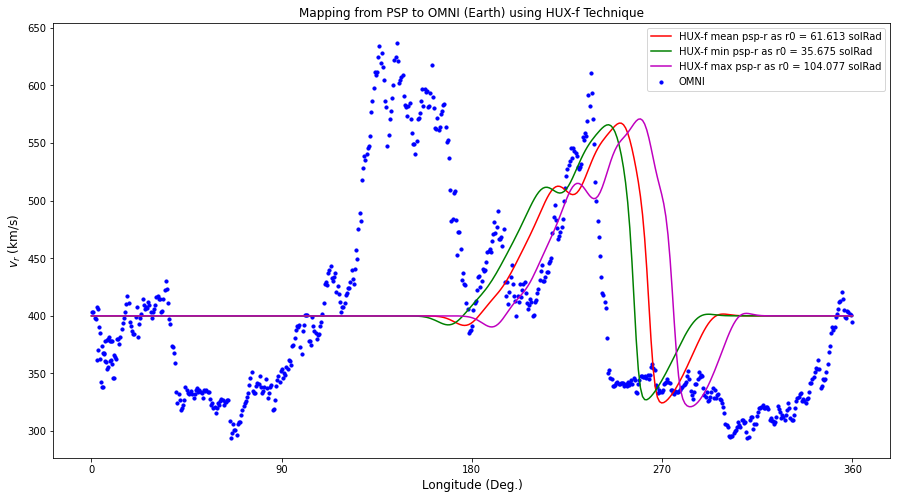

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean psp-r as r0 = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min psp-r as r0 = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max psp-r as r0 = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))




_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

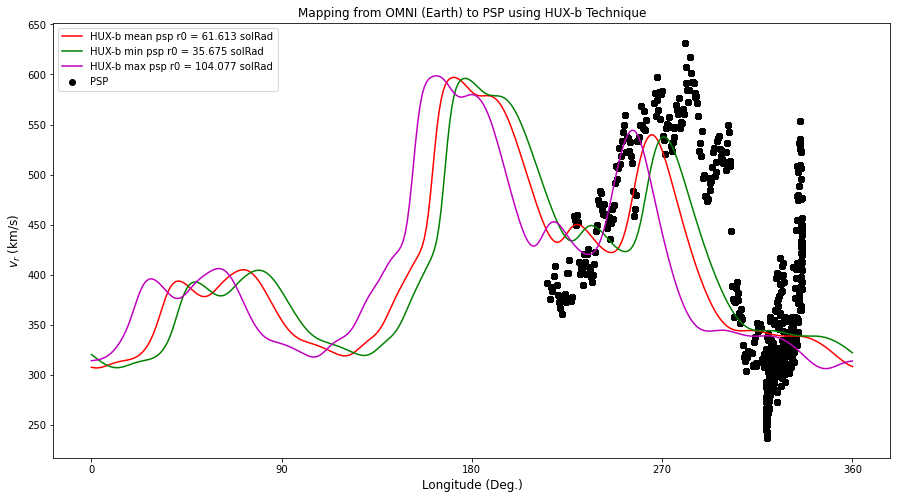

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = ax.scatter(lon_psp, psp_data.quantity('VR'), color="k", label="PSP")


_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean psp r0 = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min psp r0 = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max psp r0 = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

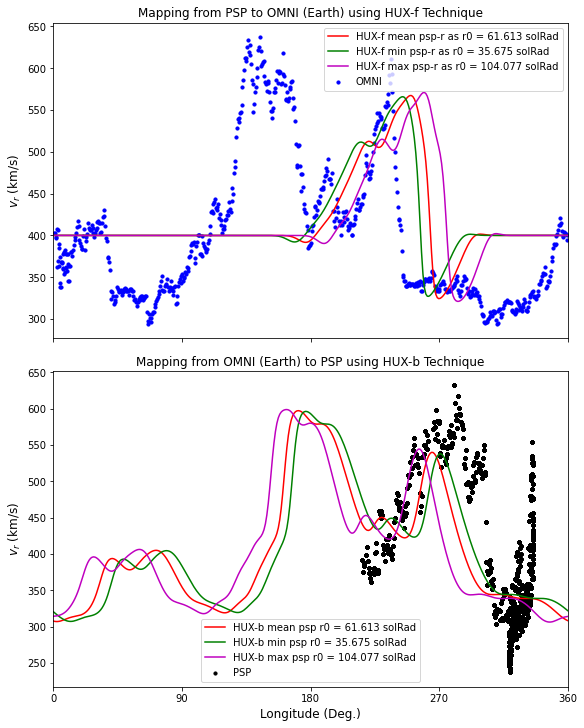

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique", fontsize=fs1)
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[0].scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

ax[0].plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean psp-r as r0 = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_min, color="g", label="HUX-f min psp-r as r0 = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_max, color="m", label="HUX-f max psp-r as r0 = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean psp r0 = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_min, color="g", label="HUX-b min psp r0 = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_max, color="m", label="HUX-b max psp r0 = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))

ax[1].scatter(lon_psp, psp_data.quantity('VR'), color="k", s=size,label="PSP")
ax[1].legend()
plt.savefig('figures/'+ case_study + '/mapping_omni_to_psp_and_back_cr' + str(cr) +'.png')